In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, TimeDistributed, Bidirectional, LSTM, Input, UpSampling2D, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import pyedflib as ped

In [2]:
# data_dir = 'data\\xy_arr_pre_int'
# X = np.load(data_dir+'\\chb01_x.npy')
# y = np.load(data_dir+'\\chb01_y.npy')
# X = np.append(X,np.load(data_dir+'\\chb03_x.npy'),axis=0)
# y = np.append(y,np.load(data_dir+'\\chb03_y.npy'),axis=0)
# X = np.append(X,np.load(data_dir+'\\chb07_x.npy'),axis=0)
# y = np.append(y,np.load(data_dir+'\\chb07_y.npy'),axis=0)
# X = np.append(X,np.load(data_dir+'\\chb09_x.npy'),axis=0)
# y = np.append(y,np.load(data_dir+'\\chb09_y.npy'),axis=0)
# X = np.append(X,np.load(data_dir+'\\chb10_x.npy'),axis=0)
# y = np.append(y,np.load(data_dir+'\\chb10_y.npy'),axis=0)


In [4]:
# X2 = np.load(data_dir+'\\chb20_x.npy')
# y2 = np.load(data_dir+'\\chb20_y.npy')

In [2]:
data_dir = 'data\\xy_arr_pre_int'
X = np.load(data_dir+'\\8patients_x.npy')
y = np.load(data_dir+'\\8patients_y.npy')

In [3]:
np.shape(y)

(29472,)

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 2),input_shape = (1280,23,1),activation='relu', padding='valid'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 2), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 2), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())

model.add(RepeatVector(1))

model.add(Bidirectional(LSTM(32,input_shape=(1280,23))))
# model.add(Bidirectional(LSTM(32,return_sequences=False)))

model.add(Dense(300,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1278, 22, 32)      224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 639, 11, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 639, 11, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 637, 10, 32)       6176      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 318, 5, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 318, 5, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 316, 4, 32)        6

In [5]:
model.compile(optimizer='adam',loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

In [7]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X,y, test_size=0.2, shuffle=True)
# x_tr2, x_te2, y_tr2, y_te2 = train_test_split(X2,y2, test_size=0.0000001, shuffle=True)

In [8]:
hist = model.fit(np.expand_dims(x_tr,3),y_tr,epochs=40,batch_size=256,validation_data=(np.expand_dims(x_te,3),y_te))

Epoch 1/40
93/93 [==============================] - ETA: 0s - loss: 0.5780 - acc: 0.6767

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[256,1280,23,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[256,1280,23,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_7880]

Function call stack:
test_function -> test_function


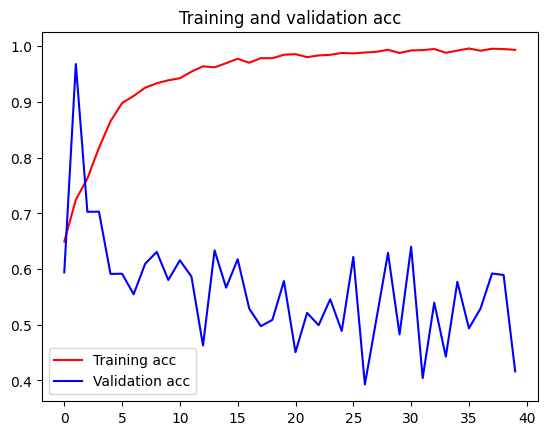

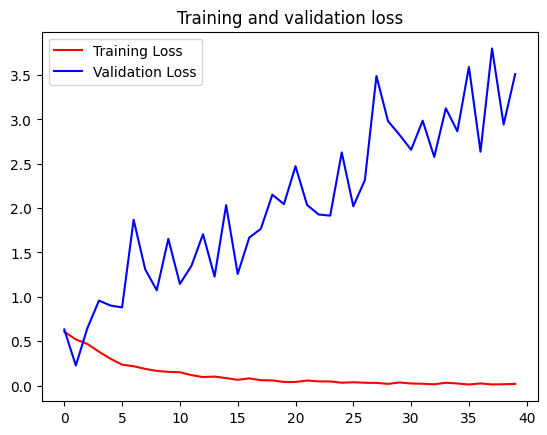

In [11]:
plot_curves(hist)

In [12]:
result = model.predict(np.expand_dims(X2,3))

In [13]:
result = result > 0.5

In [10]:
def scores(y,result):
    print("Accuracy Score: "+str(accuracy_score(y, result, normalize=True, sample_weight=None)))
    print("F1 Score: "+str(f1_score(y, result, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')))
    print("Precision Score: "+str(precision_score(y, result, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')))
    print("Recall Score: "+str(recall_score(y, result, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')))
    confusion_mtx = confusion_matrix(y, result) 
    plot_confusion_matrix(confusion_mtx, classes = range(2)) 

def plot_curves(hist):
    acc = hist.history['acc']
    loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve

Accuracy Score: 0.41631639281620175
F1 Score: 0.5157711206213347
Precision Score: 0.44068255687973995
Recall Score: 0.6217042414978984


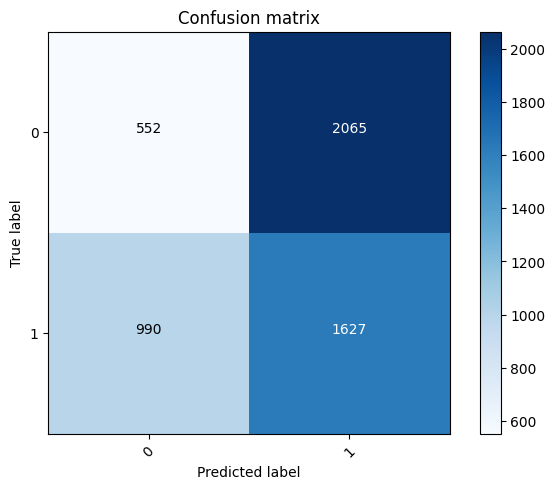

In [18]:
scores(y2,result)

In [19]:
sum(y)

7272.0